# **CNN für Handwritten Recognition**

# **First Step: Import Dataset**

In [1]:
# Import PyTorch
import torch
from torch import nn

# Import torchvision
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Import matplotlib for visualization
import matplotlib.pyplot as plt

In [2]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = ToTensor()
)

test_data = datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 9912422/9912422 [00:00<00:00, 82798535.13it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 65196821.22it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 19860695.53it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 593696.36it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# **Second Step: Split Data into batches**

In [3]:
from torch.utils.data import DataLoader

batchSize = 100

train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = batchSize,
    shuffle = True,
    num_workers=1
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = batchSize,
    shuffle = False,
    num_workers=1
)

In [4]:
train_dataloader

**Third Step: Initialize the CNN**

In [5]:
import torch.nn.functional as F
import torch.optim as optim

class MNISTModel(nn.Module):

  def __init__(self):
    super(MNISTModel, self).__init__()

    self.conv1 = nn.Conv2d(1,10,kernel_size=5)
    self.conv2 = nn.Conv2d(10,20,kernel_size=5)
    self.conv2_drop = nn.Dropout2d()
    self.fc1 = nn.Linear(320,50)
    self.fc2 = nn.Linear(50,10)


  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1,320)
    x = F.relu(self.fc1(x))
    x = F.dropout(x, training = self.training)
    x = self.fc2(x)

    return F.softmax(x)


In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

**Fourth Step: Loss function and Optimizer**

In [7]:
import requests
from pathlib import Path

request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
with open("helper_functions.py", "wb") as f:
    f.write(request.content)

In [8]:
from helper_functions import accuracy_fn
from tqdm.auto import tqdm

model = MNISTModel().to(device)

optimizer = optim.Adam(model.parameters(), lr = 0.001)

loss_fn = nn.CrossEntropyLoss()


**Next step: Function for Training  und testing**

In [9]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval() # put model in eval mode

    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

**Training and Testing Step**

In [10]:

# Train and test model
epochs = 50
for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader,
        model=model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        device=device
    )
    test_step(data_loader=test_dataloader,
        model=model,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn,
        device=device
    )

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0
---------


<ipython-input-5-b86a67cb034c>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


Train loss: 1.71407 | Train accuracy: 76.21%
Test loss: 1.52467 | Test accuracy: 93.83%

Epoch: 1
---------
Train loss: 1.50959 | Train accuracy: 95.39%
Test loss: 1.49307 | Test accuracy: 96.98%

Epoch: 2
---------
Train loss: 1.49323 | Train accuracy: 96.97%
Test loss: 1.48620 | Test accuracy: 97.67%

Epoch: 3
---------
Train loss: 1.48655 | Train accuracy: 97.58%
Test loss: 1.48158 | Test accuracy: 98.07%

Epoch: 4
---------
Train loss: 1.48310 | Train accuracy: 97.90%
Test loss: 1.48245 | Test accuracy: 97.90%

Epoch: 5
---------
Train loss: 1.48010 | Train accuracy: 98.16%
Test loss: 1.48066 | Test accuracy: 98.19%

Epoch: 6
---------
Train loss: 1.47755 | Train accuracy: 98.44%
Test loss: 1.48023 | Test accuracy: 98.13%

Epoch: 7
---------
Train loss: 1.47636 | Train accuracy: 98.53%
Test loss: 1.47846 | Test accuracy: 98.32%

Epoch: 8
---------
Train loss: 1.47512 | Train accuracy: 98.68%
Test loss: 1.47571 | Test accuracy: 98.54%

Epoch: 9
---------
Train loss: 1.47368 | Train 

**Predictions with the model**

In [11]:
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor1 = torch.cat(y_preds)

Making predictions:   0%|          | 0/100 [00:00<?, ?it/s]

<ipython-input-5-b86a67cb034c>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


In [12]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 11.8 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [13]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [14]:
class_names = train_data.classes

**ConfusionMatrix**

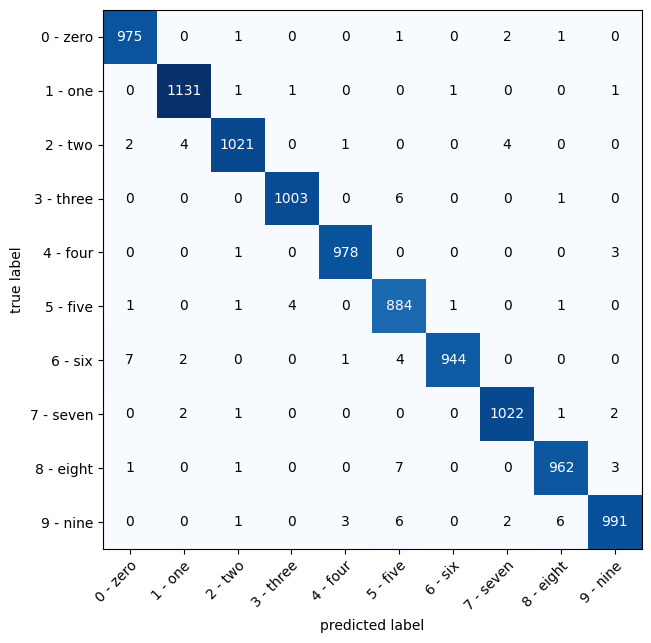

In [15]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor1,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

**Test on real Data**

In [16]:
import cv2

In [17]:
true_sample = torch.arange(0,10,)

<ipython-input-5-b86a67cb034c>:24: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x)


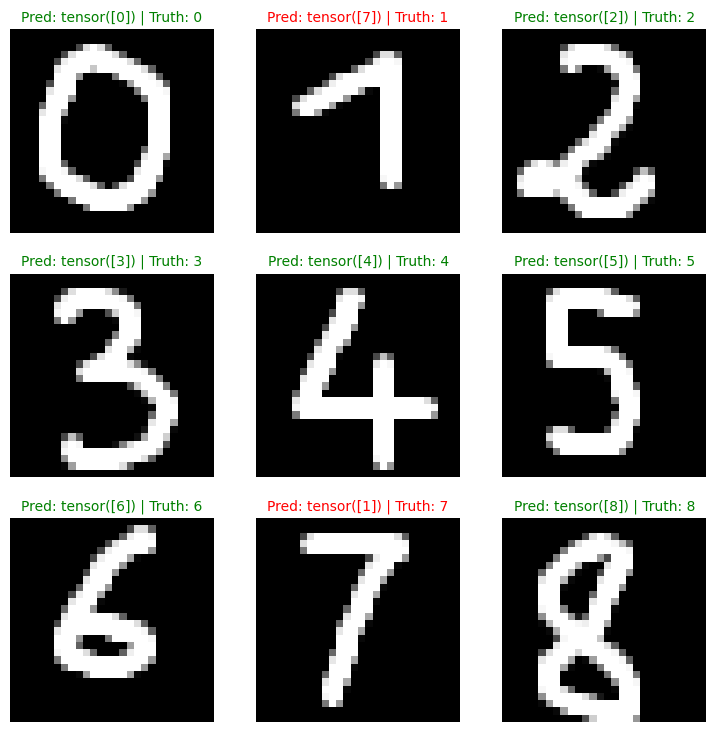

In [22]:
# Load the model and set it to evaluation mode
model.eval()

# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i in range (0,9):

    # Create a subplot
  plt.subplot(nrows, ncols, i+1)

    # Plot the target image
      # Load and preprocess the image
  input_data = cv2.imread(str(i)+".png")
  input_data = cv2.cvtColor(input_data, cv2.COLOR_BGR2GRAY)
  input_data = cv2.resize(input_data, (28, 28))
  sample = input_data.copy()
  input_data = torch.from_numpy(input_data).unsqueeze(0).unsqueeze(0).to(device)
  input_data = input_data.to(torch.float32)
  plt.imshow(sample, cmap="gray")
  with torch.no_grad():
    # Find the prediction label (in text form, e.g. "Sandal")
    output_data = model(input_data)
    pred_label = output_data.argmax(dim = 1)

    # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = true_sample[i]

    # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);